In [1]:
import numpy as np
import itertools as it
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
# dummy sequence (binary for a start)
t = np.arange(100)
yBinaryTrue = np.zeros(100)
yBinaryTrue[6:28+1] = 1 #u1
yBinaryTrue[52:56+1] = 1 #u2
yBinaryTrue[71:80+1] = 1 #u3
yBinaryTrue[85:89+1] = 1 #u4
yBinaryPred = np.zeros(100)
yBinaryPred[10:16+1] = 1 #u1
yBinaryPred[19:30+1] = 1 #u2
yBinaryPred[51:58+1] = 1 #u3

In [19]:
np.sum((yBinaryTrue==1)*(yBinaryPred==0))

21

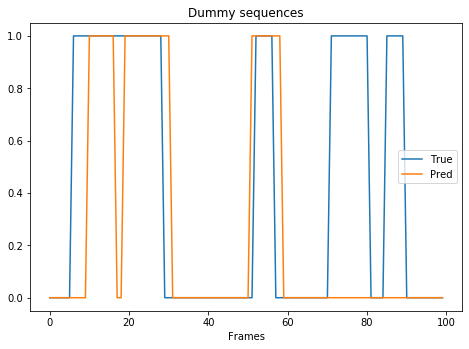

In [3]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(t,yBinaryTrue,label='True')
ax.plot(t,yBinaryPred,label='Pred')
ax.set_title('Dummy sequences')
ax.set_xlabel('Frames')
ax.legend()
plt.show()

In [4]:
def valuesConsecutive(data):
    # returns list of (value, start, end (+1), nb of values) (excluding zero values)
    g = it.groupby(enumerate(data), lambda x:x[1])
    l = [(x[0], list(x[1])) for x in g if x[0] != 0]
    #[(x[0], len(x[1]), x[1][0][0]) for x in l]
    return [(x[0], x[1][0][0], x[1][0][0]+len(x[1]), len(x[1])) for x in l]

def matrixMatch(dataTrue,dataPred,consecTrue,consecPred,seqLength):
    # returns matrix of match score to calculate best matches
    #l = dataTrue.size
    l = seqLength
    tempVectorTrue = np.ones(l)
    tempVectorPred = np.ones(l)
    tempVector = np.ones(l)
    #consecTrue = valuesConsecutive(dataTrue)
    #consecPred = valuesConsecutive(dataPred)
    nbUnitsTrue = len(consecTrue)
    nbUnitsPred = len(consecPred)
    matrixM = np.zeros((nbUnitsTrue,nbUnitsPred))
    for iTrue in range(nbUnitsTrue):
        valuesUnitTrue = consecTrue[iTrue]
        tempVectorTrue[:valuesUnitTrue[1]] = 0
        tempVectorTrue[valuesUnitTrue[2]:] = 0
        for iPred in range(nbUnitsPred):
            valuesUnitPred = consecPred[iPred]
            tempVectorPred[:valuesUnitPred[1]] = 0
            tempVectorPred[valuesUnitPred[2]:] = 0
            tempVector = tempVectorTrue*tempVectorPred
            matrixM[iTrue,iPred] = 2 * (valuesUnitTrue[0] == valuesUnitPred[0]) * np.sum(tempVector)/(valuesUnitTrue[3] + valuesUnitPred[3])
            tempVectorPred[:] = 1
        tempVectorTrue[:] = 1
    return matrixM

def idxBestMatches(dataTrue,dataPred,matMatch):
    # returns best matches for each true unit, and for each detected unit
    matMatch = matrixMatch(dataTrue,dataPred,valuesConsecutive(dataTrue),valuesConsecutive(dataPred),dataTrue.size)
    return np.argmax(matMatch,axis=0), np.argmax(matMatch,axis=1)

def isMatched(idxTrue,idxPred,tp,tr,consecTrue,consecPred,seqLength):
    l = seqLength
    tempVectorTrue = np.ones(l)
    tempVectorPred = np.ones(l)
    valuesUnitTrue = consecTrue[idxTrue]
    valuesUnitPred = consecPred[idxPred]
    tempVectorTrue[:valuesUnitTrue[1]] = 0
    tempVectorTrue[valuesUnitTrue[2]:] = 0
    tempVectorPred[:valuesUnitPred[1]] = 0
    tempVectorPred[valuesUnitPred[2]:] = 0
    tempVector = tempVectorTrue*tempVectorPred
    intersect = np.sum(tempVectorTrue * tempVectorPred)
    if intersect/valuesUnitPred[3] > tp and intersect/valuesUnitTrue[3] > tr and valuesUnitTrue[0] == valuesUnitPred[0]:
        return 1
    else:
        return 0

def prfStar(dataTrue,dataPred,step):
    # Returns P*(tp,0), P*(0,tr), R*(tp,0), R*(0,tr), F1*(tp,0), F1*(0,tr)
    seqLength = dataTrue.size
    tpVector = np.arange(0,1+step,step)
    trVector = np.arange(0,1+step,step)
    nbValues = tpVector.size
    
    pStarTp = np.zeros(nbValues)
    pStarTr = np.zeros(nbValues)
    rStarTp = np.zeros(nbValues)
    rStarTr = np.zeros(nbValues)
    fStarTp = np.zeros(nbValues)
    fStarTr = np.zeros(nbValues)
    
    consecTrue = valuesConsecutive(dataTrue)
    consecPred = valuesConsecutive(dataPred)
    
    nbUnitsTrue = len(consecTrue)
    nbUnitsPred = len(consecPred)
    
    M = matrixMatch(dataTrue,dataPred,consecTrue,consecPred,seqLength)
    
    idxBestMatchesTrue, idxBestMatchesPred = idxBestMatches(dataTrue,dataPred,M)
    
    for iPred in range(nbUnitsPred):
        idxBestMatchTrue = idxBestMatchesTrue[iPred]
        for iTp in range(nbValues):
            pStarTp[iTp] += isMatched(idxBestMatchTrue,iPred,tpVector[iTp],0,consecTrue,consecPred,seqLength)
        for iTr in range(nbValues):
            pStarTr[iTr] += isMatched(idxBestMatchTrue,iPred,0,trVector[iTr],consecTrue,consecPred,seqLength)
    pStarTp /= nbUnitsPred
    pStarTr /= nbUnitsPred
    
    for iTrue in range(nbUnitsTrue):
        idxBestMatchPred = idxBestMatchesPred[iTrue]
        for iTp in range(nbValues):
            rStarTp[iTp] += isMatched(iTrue,idxBestMatchPred,tpVector[iTp],0,consecTrue,consecPred,seqLength)
        for iTr in range(nbValues):
            rStarTr[iTr] += isMatched(iTrue,idxBestMatchPred,0,trVector[iTr],consecTrue,consecPred,seqLength)
    rStarTp /= nbUnitsTrue
    rStarTr /= nbUnitsTrue
    
    fStarTp = 2 * 1. / (1. / pStarTp + 1. / rStarTp)
    fStarTr = 2 * 1. / (1. / pStarTr + 1. / rStarTr)
    
    return pStarTp, pStarTr, rStarTp, rStarTr, fStarTp, fStarTr

def integralValues(fTp, fTr, step):
    Ip = 0
    Ir = 0
    t = np.arange(0,1+step,step)
    nbValues = t.size
    for i in range(nbValues-1):
        midTp = 0.5 * (fTp[i] + fTp[i+1])
        midTr = 0.5 * (fTr[i] + fTr[i+1])
        Ip += midTp*step
        Ir += midTr*step
    return Ip, Ir, 0.5*(Ip+Ir)

In [5]:
valuesConsecutive(yBinaryTrue)

[(1.0, 6, 29, 23), (1.0, 52, 57, 5), (1.0, 71, 81, 10), (1.0, 85, 90, 5)]

In [6]:
valuesConsecutive(yBinaryPred)

[(1.0, 10, 17, 7), (1.0, 19, 31, 12), (1.0, 51, 59, 8)]

In [7]:
M = matrixMatch(yBinaryTrue,yBinaryPred,valuesConsecutive(yBinaryTrue),valuesConsecutive(yBinaryPred),yBinaryTrue.size)
print(M)

[[0.46666667 0.57142857 0.        ]
 [0.         0.         0.76923077]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]


In [8]:
idxBestMatchesTrue, idxBestMatchesPred = idxBestMatches(yBinaryTrue,yBinaryPred,M)

In [9]:
idxBestMatchesPred

array([1, 2, 0, 0])

In [10]:
idxBestMatchesTrue

array([0, 0, 1])

In [11]:
isMatched(2,2,0.9,0,valuesConsecutive(yBinaryTrue),valuesConsecutive(yBinaryPred),100)

0

/Users/belissen/miniconda3/envs/cslr_models/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
/Users/belissen/miniconda3/envs/cslr_models/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide


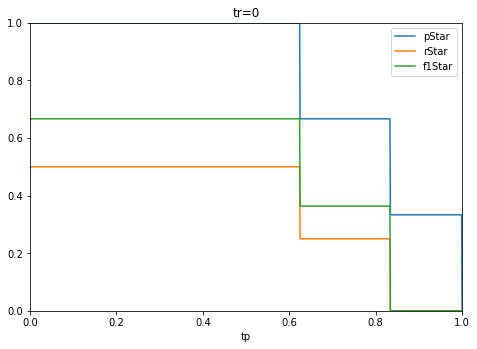

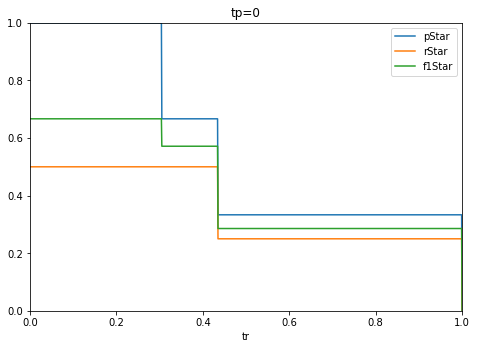

In [12]:
step=0.001

pStarTp, pStarTr, rStarTp, rStarTr, fStarTp, fStarTr = prfStar(yBinaryTrue,yBinaryPred,step)

t = np.arange(0,1+step,step)
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(t,pStarTp,label='pStar')
ax.plot(t,rStarTp,label='rStar')
ax.plot(t,fStarTp,label='f1Star')
ax.set_title('tr=0')
ax.set_xlabel('tp')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend()
plt.show()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(t,pStarTr,label='pStar')
ax.plot(t,rStarTr,label='rStar')
ax.plot(t,fStarTr,label='f1Star')
ax.set_title('tp=0')
ax.set_xlabel('tr')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend()
plt.show()

In [13]:
integralValues(fStarTp, fStarTr, step)

(0.4923333333333263, 0.4387142857142826, 0.46552380952380445)